In [1]:
from collections import Counter
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import datetime
import copy
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import Birch
import time
from sklearn.model_selection import train_test_split
import calendar
from scipy import spatial
import os
import random

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (8.0, 6.0)

In [2]:
import sys
sys.path.append('../src/')
import preprocessing_lib as plib
import clustering_lib as clustlib
import exploration_lib as explib


In [3]:
online_table_location = '../data_folder/Online_Tracker_Feb01/'

In [4]:
online_tracker_ori = plib.read_online_table(online_table_location).query('REL_CMP_PROGRAM_GROUP_NAME != "CAMP/TRP"')

reading from ../data_folder/Online_Tracker_Feb01/


In [5]:
online_tracker_ori.shape

(573514, 231)

In [8]:
feature_dict = {'REL_CMP_FAIL_CODE_LIST': 0.95,
                'GREEN_WRENCH_FAULT_CODE_LIST':0.95,
                'REL_OEM_NAME':0.5,
                #'GREEN_WRENCH_NUM_LIST':0.1,
                'REL_ANALYSIS_RATE_CAT':'specific',
                'REL_CMP_ENGINE_MILES_LIST': 'specific',
                'REL_CMP_FAIL_DATE_LIST':'specific',
                'REL_CMP_SUM_NET_AMOUNT':'impute_take_log',
                #'CMP_SUM_MATERIALS_AMOUNT':'impute_take_log'
                }

transformed_table_whole, clustering_features, clustering_ranges = \
    plib.preprocessing(online_tracker_ori, feature_dict, verbose=True)

Start main table preprocessing
Number of features to create is 7
Replaced Null in string type column REL_ANALYSIS_RATE_CAT to Unknown
Replaced Null in list type column REL_CMP_CLAIM_DATE_LIST
Replaced Null in list type column REL_CMP_FAIL_DATE_LIST
Replaced Null in list type column GREEN_WRENCH_FAULT_CODE_LIST
Replaced Null in list type column REL_CMP_FAIL_CODE_LIST
Replaced Null in string type column REL_OEM_NAME to Unknown
Replaced Null in list type column GREEN_WRENCH_NUM_LIST
Replaced Null in list type column REL_CMP_ENGINE_MILES_LIST
Start Processing Features
Dummify feature REL_CMP_FAIL_CODE_LIST using quantile 0.95


  0%|          | 0/30 [00:00<?, ?it/s]

Create extra features on fail code


100%|██████████| 54/54 [01:16<00:00,  1.42s/it]


Dummify feature GREEN_WRENCH_FAULT_CODE_LIST using quantile 0.95


100%|██████████| 33/33 [00:05<00:00,  5.60it/s]


Dummify feature REL_OEM_NAME using quantile 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

Create Engine Category Feature


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Create Log Miles Feature
Create Log Normalized Age Feature
Imput and take log on REL_CMP_SUM_NET_AMOUNT
Column name of the new feature is REL_CMP_SUM_NET_AMOUNT_IMPUTED_NORMALIZED


In [12]:
transformed_table_whole.columns.values

array(['ESN', 'EARLIEST_INDICATION_DATE', 'DSID', 'REL_ESN',
       'REL_FAILURE_DATE', 'REL_CMP_SUM_NET_AMOUNT',
       'REL_CMP_SUM_MATERIALS_AMOUNT', 'REL_CMP_SUM_MARKUP_AMOUNT',
       'REL_CMP_SUM_REPAIR_LABOR_AMOUNT',
       'REL_CMP_SUM_OTHER_EXPENSE_AMOUNT', 'REL_CMP_SUM_DEDUCTIBLE_AMOUNT',
       'REL_CMP_PROGRAM_GROUP_CODE', 'REL_CMP_PROGRAM_GROUP_NAME',
       'REL_CMP_PROGRAM_ACCOUNT_CODE', 'REL_CMP_FAIL_DATE_LIST',
       'REL_CMP_CLAIM_DATE_LIST', 'REL_CMP_PAYMENT_DATE_LIST',
       'REL_CMP_IN_SERVICE_DATE_LIST', 'REL_CMP_ESN_LIST',
       'REL_CMP_FAIL_CODE_LIST', 'REL_CMP_FAIL_CODE_DESC_LIST',
       'REL_CMP_DISTRIBUTOR_CODE_LIST', 'REL_CMP_CLAIM_NUM_LIST',
       'REL_CMP_ENGINE_MILES_LIST', 'DSID_CREATE_DATE',
       'DSID_LAST_UPDATED_DATE', 'GREEN_WRENCH_FAULT_CODE_LIST',
       'GREEN_WRENCH_NUM_LIST', 'GREEN_WRENCH_LIST', 'CSS_INDICATOR_LIST',
       'DSID_CURRENT_STATUS_LIST', 'GREEN_WRENCH_DESC_LIST',
       'NON_GREEN_WRENCH_FAULT_CODE_LIST', 'DSID_LIST',
   

In [13]:
# oem_col_names = []
# for cur_name in transformed_table_whole.columns.values:
#     if cur_name[:13] == 'REL_OEM_NAME_':
#         oem_col_names.append(cur_name)

In [15]:
transformed_table = transformed_table_whole.loc[transformed_table_whole['INCDT_ISSUE_LABEL'].\
                                              apply(lambda x: x is not None),:]
##Matrix of features values
data = transformed_table_whole.loc[:, clustering_features].values

In [16]:
optimal_weights = [2.75, 2.0, 1.0, 4.0, 1.5, 3.75, 2.25, 2.5, 0.25]
n_clusters = 140

Current window: 2011-06-01 00:00:00
Time to compute: 2.4748690128326416
Current window: 2011-07-01 00:00:00
Time to compute: 2.109729051589966
Current window: 2011-08-01 00:00:00
Time to compute: 2.0853800773620605
Current window: 2011-09-01 00:00:00
Time to compute: 2.3428008556365967
Current window: 2011-10-01 00:00:00
Time to compute: 2.08273983001709
Current window: 2011-11-01 00:00:00
Time to compute: 2.352221727371216
Current window: 2011-12-01 00:00:00
Time to compute: 2.079056978225708
Current window: 2012-01-01 00:00:00
Time to compute: 2.120534896850586
Current window: 2012-02-01 00:00:00
Time to compute: 2.1040399074554443
Current window: 2012-03-01 00:00:00
Time to compute: 2.1010842323303223
Current window: 2012-04-01 00:00:00
Time to compute: 2.331092119216919
Current window: 2012-05-01 00:00:00
Time to compute: 2.088582992553711
Current window: 2012-06-01 00:00:00
Time to compute: 2.3770251274108887
Current window: 2012-07-01 00:00:00
Time to compute: 2.092344284057617
C

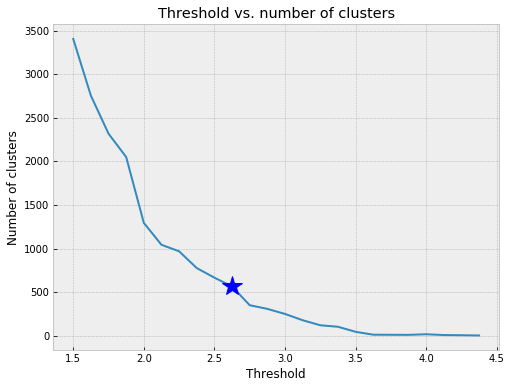

In [19]:
window_size, window_step, order_of_magnitude = (3, 0), (1, 0), n_clusters * 4
algorithm, n_clusters_algorithm = 'hierarchical', 'birch_variable'

###Optimal threshold for the moving windows framework
optimal_threshold = clustlib.threshold_tuning(data = data,
                                              df = transformed_table_whole,
                                              clustering_ranges = clustering_ranges,
                                              weights = optimal_weights,
                                              algorithm = n_clusters_algorithm,
                                              size = window_size,
                                              step = window_step,
                                              test_range = [1.5 + (s/8) for s in range(24)],
                                              order_of_magnitude = order_of_magnitude,
                                              do_print = True, 
                                              do_plot = True)

In [20]:
optimal_threshold

2.625

Current window: 2011-06-01 00:00:00
Number of clusters in the window: 3
Time Cost to compute: 2.3132171630859375
Time to compute heirarchical clustering:0.002492189407348633
Current window: 2011-07-01 00:00:00
Number of clusters in the window: 5
Time Cost to compute: 1.9449679851531982
Time to compute heirarchical clustering:0.00109100341796875
Current window: 2011-08-01 00:00:00
Number of clusters in the window: 6
Time Cost to compute: 2.0015900135040283
Time to compute heirarchical clustering:0.0009889602661132812
Current window: 2011-09-01 00:00:00
Number of clusters in the window: 6
Time Cost to compute: 2.09256911277771
Time to compute heirarchical clustering:0.001399993896484375
Current window: 2011-10-01 00:00:00
Number of clusters in the window: 6
Time Cost to compute: 2.0853898525238037
Time to compute heirarchical clustering:0.001355886459350586
Current window: 2011-11-01 00:00:00
Number of clusters in the window: 7
Time Cost to compute: 2.327723979949951
Time to compute heir

Time to compute heirarchical clustering:169.6008641719818
Current window: 2015-06-01 00:00:00
Number of clusters in the window: 1155
Time Cost to compute: 3.9840500354766846
Time to compute heirarchical clustering:187.77789902687073
Current window: 2015-07-01 00:00:00
Number of clusters in the window: 1065
Time Cost to compute: 4.31644606590271
Time to compute heirarchical clustering:194.4743092060089
Current window: 2015-08-01 00:00:00
Number of clusters in the window: 996
Time Cost to compute: 4.443090915679932
Time to compute heirarchical clustering:219.52116417884827
Current window: 2015-09-01 00:00:00
Number of clusters in the window: 1016
Time Cost to compute: 5.392059803009033
Time to compute heirarchical clustering:254.51768612861633
Current window: 2015-10-01 00:00:00
Number of clusters in the window: 940
Time Cost to compute: 5.676944017410278
Time to compute heirarchical clustering:283.4921941757202
Current window: 2015-11-01 00:00:00
Number of clusters in the window: 929
Ti

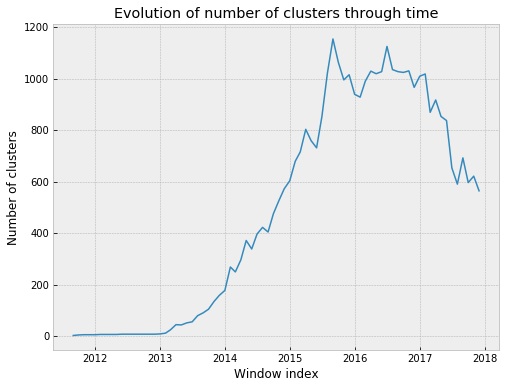

In [21]:
###Perform the clustering
clustering_results, start_window, end_window, anchor = \
    clustlib.moving_windows_framework(data = data,
                                      df = transformed_table_whole,
                                      clustering_ranges = clustering_ranges,
                                      weights = optimal_weights,
                                      size = window_size,
                                      step = window_step,
                                      algorithm = algorithm,
                                      n_clusters_algorithm = n_clusters_algorithm,
                                      threshold = optimal_threshold,
                                      compute_centroids = True,
                                      do_print = True,
                                      do_plot = True)

In [22]:
clustering_results.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])

In [23]:
#Functions
##Takes as arguments a dataframe, the start window, end_window, clustering results,
    #a step ip that the function should extract, and the optional name of the date column 
##Returns the labeled subset of the dateframe corresponding the the step_id of interest
def extract_window_rep(df, #data frame containing at least the date_col_name column
                   start_window, #list of datetimes
                   end_window, #list of datetimes
                   clustering_results, #clustering_results (list of labels)
                   step_id, #step_id that should be extracted (integer)
                   date_col_name='EARLIEST_RECORD_DATE'): #date column name
    sub_df = df[(start_window[step_id] <= df[date_col_name]) & (df[date_col_name] < end_window[step_id])]
    sub_df['CLUSTER_ID'] = clustering_results[step_id]
    return(sub_df.loc[:, ['ID', 'CLUSTER_ID']])

##Takes as arguments a dataframe, the start window, end_window, clustering results,
    #the path range, and the optional name of the date column
##Returns a dictionary of labeled subsets to avoid recomputing them
def map_windows_rep(df,#data frame containing at least the date_col_name column
                start_window,#list of datetimes
                end_window,#list of datetimes
                clustering_results,#clustering_results (list of labels)
                path_range,# (a,b) where a is the first window index in the path and b the last one
                date_col_name='EARLIEST_RECORD_DATE'):#date column name
    windows={}
    for i in tqdm(range(path_range[0],path_range[1]+1)):
        windows[int(i)] = extract_window_rep(df=df,
                                         start_window=start_window,
                                         end_window=end_window,
                                         clustering_results=clustering_results,
                                         step_id=i,
                                         date_col_name=date_col_name)
    return(windows)

In [24]:
##Windows dictionary (optional: convert time complexity to space memory)
windows = map_windows_rep(transformed_table_whole,
                          start_window,
                          end_window,
                          clustering_results,
                          (0, 75))

  0%|          | 0/76 [00:00<?, ?it/s]/Users/ph697/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
100%|██████████| 76/76 [00:44<00:00,  1.70it/s]


In [25]:
transformed_table_rep = transformed_table_whole.copy()
for i in tqdm(range(len(windows))):
    transformed_table_rep = transformed_table_rep.\
        merge(windows[i].loc[:, ['ID', 'CLUSTER_ID']], on = 'ID', how = 'left').\
        rename(columns = {'CLUSTER_ID':str(end_window[i])[:10]})

100%|██████████| 76/76 [45:22<00:00, 35.82s/it]


In [26]:
transformed_table_rep.shape

(573514, 541)

In [27]:
transformed_table_rep.columns.values

array(['ESN', 'EARLIEST_INDICATION_DATE', 'DSID', 'REL_ESN',
       'REL_FAILURE_DATE', 'REL_CMP_SUM_NET_AMOUNT',
       'REL_CMP_SUM_MATERIALS_AMOUNT', 'REL_CMP_SUM_MARKUP_AMOUNT',
       'REL_CMP_SUM_REPAIR_LABOR_AMOUNT',
       'REL_CMP_SUM_OTHER_EXPENSE_AMOUNT', 'REL_CMP_SUM_DEDUCTIBLE_AMOUNT',
       'REL_CMP_PROGRAM_GROUP_CODE', 'REL_CMP_PROGRAM_GROUP_NAME',
       'REL_CMP_PROGRAM_ACCOUNT_CODE', 'REL_CMP_FAIL_DATE_LIST',
       'REL_CMP_CLAIM_DATE_LIST', 'REL_CMP_PAYMENT_DATE_LIST',
       'REL_CMP_IN_SERVICE_DATE_LIST', 'REL_CMP_ESN_LIST',
       'REL_CMP_FAIL_CODE_LIST', 'REL_CMP_FAIL_CODE_DESC_LIST',
       'REL_CMP_DISTRIBUTOR_CODE_LIST', 'REL_CMP_CLAIM_NUM_LIST',
       'REL_CMP_ENGINE_MILES_LIST', 'DSID_CREATE_DATE',
       'DSID_LAST_UPDATED_DATE', 'GREEN_WRENCH_FAULT_CODE_LIST',
       'GREEN_WRENCH_NUM_LIST', 'GREEN_WRENCH_LIST', 'CSS_INDICATOR_LIST',
       'DSID_CURRENT_STATUS_LIST', 'GREEN_WRENCH_DESC_LIST',
       'NON_GREEN_WRENCH_FAULT_CODE_LIST', 'DSID_LIST',
   

In [28]:
extract_col_names = [str(x)[:10] for x in end_window]

In [29]:
extract_col_names.extend(['ESN', 'ID', 'EARLIEST_INDICATION_DATE', 'REL_OEM_NAME', 
                          'REL_CMP_SUM_NET_AMOUNT', 'INCDT_ISSUE_LABEL', 
                          'ENGINE_AGE', 'LAST_MILE_RECORDED_IMPUTED'])

In [23]:
transformed_table_rep.loc[:, extract_col_names].\
    to_csv('../data_folder/clustering_results/online_table_clustering_result_Feb12.csv', index = False)

/Users/ph697/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/Users/ph697/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [30]:
import pyarrow as pa
table = pa.Table.from_pandas(transformed_table_rep.loc[:, extract_col_names])
pq.write_table(table, '../data_folder/clustering_results/online_table_clustering_result_Feb14.parquet')

/Users/ph697/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/ph697/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
